In [301]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import MNIST, FashionMNIST, CIFAR100
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import time
from sklearn.model_selection import ParameterGrid
import os

**Sprawdzenie możliwości wykorzystania GPU - NVIDIA CUDA**

In [302]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [303]:
transform_train_mnists = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test_mnists = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [304]:
train_set_fashion = FashionMNIST(root='./data', download = True, train=True, transform=transform_train_mnists)
print(f"MNIST FASHION test number of samples = {len(train_set_fashion)}")
validation_set_fashion = FashionMNIST(root='./data', download = False, train=False, transform=transform_test_mnists)
print(f"MNIST FASHION number of samples = {len(validation_set_fashion)}")

MNIST FASHION test number of samples = 60000
MNIST FASHION number of samples = 10000


In [305]:
# train_loader_fashion = torch.utils.data.DataLoader(train_set_fashion, batch_size=64, shuffle=True)
# test_loader_fashion = torch.utils.data.DataLoader(validation_set_fashion, batch_size=64, shuffle=False)
# print("FashionMNIST ready and steady")

In [306]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

**Przepisana wersja tego samego modelu z wykorzystaniem warstw typu "Sequential"**



In [307]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(64, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.25),
#             nn.Linear(64 * 8 * 8, 512),
#             nn.ReLU(),
#             nn.Dropout(0.25),
#             nn.Linear(512, 10),
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

**Deklaracja modeli**

In [308]:
# model_fashion = CNN()
# criterion_fashion = nn.CrossEntropyLoss()
# optimizer_fashion = optim.Adam(model_fashion.parameters())

# criterion_fashion = nn.NLLLoss()
# optimizer_fashion = optim.SGD(model_fashion.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# criterion_fashion = nn.MultiMarginLoss()
# criterion_fashion = nn.CrossEntropyLoss()
# optimizer_fashion = optim.RMSprop(model_fashion.parameters(), lr=0.01, alpha=0.9, eps=1e-08, weight_decay=5e-4, momentum=0.9, centered=False)

**Funkcja trenująca z możliwym wykorzystaniem technologii CUDA - po odkomentowaniu**

In [309]:
def train_model(model, loader, criterion, optimizer, epochs):
    start_time = time.time()
    losses = []
    accuracies = []
    f1_scores = []
    # model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        running_f1_score = 0.0

        epoch_predictions = []
        epoch_true_labels = []

        for i, data in enumerate(loader, 0):
            inputs, labels = data
            # inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            accuracy = accuracy_score(labels, predicted)
            f1 = f1_score(labels, predicted, average='weighted')
            # accuracy = accuracy_score(labels.cpu(), predicted.cpu())
            # f1 = f1_score(labels.cpu(), predicted.cpu(), average='weighted')
            running_accuracy += accuracy
            running_f1_score += f1

            epoch_predictions.extend(predicted.tolist())
            epoch_true_labels.extend(labels.tolist())
            if i % 100 == 99:
                avg_loss = round(running_loss / 100, 3)
                avg_accuracy = round(running_accuracy / 100, 3)
                avg_f1 = round(running_f1_score / 100, 3)
                print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss} accuracy: {avg_accuracy * 100}% f1_score {avg_f1}")
                losses.append(avg_loss)
                accuracies.append(avg_accuracy)
                f1_scores.append(avg_f1)
                running_loss = 0.0
                running_accuracy = 0.0
                running_f1_score = 0.0
    end_time = time.time()
    elapsed_time = end_time - start_time
    return losses, accuracies, f1_scores, elapsed_time


**Ewaluacja procesu uczenia**

In [310]:
# def evaluate_model(dataset_name, model, loader, criterion):
#     correct = 0
#     total = 0
#     running_loss = 0.0
#     predictions = []
#     true_labels = []
#     with torch.no_grad():
#         for data in loader:
#             images, labels = data
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             predictions.extend(predicted.tolist())
#             true_labels.extend(labels.tolist())
#     accuracy = correct / total
#     loss = running_loss / len(loader)
#     f1 = f1_score(true_labels, predictions, average='weighted')
#     print(f"{dataset_name} accuracy on the test set: {accuracy * 100:.2f}%")
#     return accuracy, f1, loss

In [311]:
def evaluate_model(dataset_name, model, loader, criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    predictions = []
    true_labels = []
    losses = []
    accuracies = []
    f1_scores = []

    with torch.no_grad():
        for i, data in enumerate(loader):
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
            losses.append(loss.item())

        accuracy = correct / total
        loss = running_loss / len(loader)
        f1 = f1_score(true_labels, predictions, average='weighted')
        accuracies.append(accuracy)
        f1_scores.append(f1)

    print(f"{dataset_name} accuracy on the test set: {accuracy * 100:.2f}%")
    return accuracy, f1, loss, losses, accuracies, f1_scores

In [312]:
def train_and_evaluate(dataset_name, model, loader, criterion, optimizer, epochs):
  print("TRAINING PHASE...")
  losses_train, accuracies_train, f1_scores_train, elapsed_time_train = train_model(model, loader, criterion, optimizer, epochs)
  print("TRAINING PHASE DONE.")
  print("EVALUATION SCORE")
  accuracy_test, f1_test, loss_test, losses_test, accuracies_test, f1_scores_test = evaluate_model(dataset_name, model, loader, criterion)
  # return losses, accuracies, f1_scores, predictions, true_labels
  return losses_train, accuracies_train, f1_scores_train, elapsed_time_train, accuracy_test, f1_test, loss_test, losses_test, accuracies_test, f1_scores_test

In [313]:
# # lolosses_train, accuracies_train, f1_scores_train, elapsed_time_train, accuracy_test, f1_test, loss_test, predictions_test, true_labels_test = train_and_evaluate("MNIST_FASHION", model_fashion, train_loader_fashion, criterion_fashion, optimizer_fashion, epochs=10)
# losses_train, accuracies_train, f1_scores_train, elapsed_time_train, accuracy_test, f1_test, loss_test = train_and_evaluate("MNIST_FASHION", model_fashion, train_loader_fashion, criterion_fashion, optimizer_fashion, epochs=10)
# print("Training Metrics:")
# print("Losses:", losses_train)
# print("Accuracies:", accuracies_train)
# print("F1 Scores:", f1_scores_train)
# print("Elapsed Time:", elapsed_time_train)

# print("\nTesting Metrics:")
# print("Accuracy:", accuracy_test)
# print("F1 Score:", f1_test)
# print("Loss:", loss_test)

**Tabelaryczne podsumowanie**

In [314]:
output_metrics = {
    "Param Set": ["CrossEntropyLoss, Adam, 64", "Negative Log Likelihood Loss, SGD, 32", "CrossEntropyLoss, RMSprop, 128"],
    "Time [s]": [1571.284581899643, 2051.3786005973816, 1826.8103711605072],
    "Loss": [0.21530187095024947, 0.27598238386015095, 2.32193346064228],
    "Accuracy [%]": [0.9196 * 100, 0.8966833333333334 * 100, 0.1001 * 100]
}
df = pd.DataFrame(output_metrics)
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+---------------------------------------+------------+----------+----------------+
|    | Param Set                             |   Time [s] |     Loss |   Accuracy [%] |
+====+=======================================+============+==========+================+
|  0 | CrossEntropyLoss, Adam, 64            |    1571.28 | 0.215302 |        91.96   |
+----+---------------------------------------+------------+----------+----------------+
|  1 | Negative Log Likelihood Loss, SGD, 32 |    2051.38 | 0.275982 |        89.6683 |
+----+---------------------------------------+------------+----------+----------------+
|  2 | CrossEntropyLoss, RMSprop, 128        |    1826.81 | 2.32193  |        10.01   |
+----+---------------------------------------+------------+----------+----------------+


**Możliwość zapisu modelu do pliku**

In [315]:
# torch.save(model.state_dict(), "model.pth")

**Hiperparametryzacja modelu z wykorzystaniem techniki "ParameterGrid"**

In [316]:
hyperparameters_grid = {
    'criterion': [nn.CrossEntropyLoss(), nn.NLLLoss()],
    # 'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'optimizer': [(torch.optim.Adam, {}),
                (torch.optim.SGD, {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 5e-4}),
                (torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9, 'eps': 1e-08, 'weight_decay': 5e-4, 'momentum': 0.9, 'centered': False})],
    'batch_size': [32, 64, 128],
    'epochs': [10]
}

param_grid = ParameterGrid(hyperparameters_grid)

print(f"Params Grid {len(param_grid)}")
for params in param_grid:
    print("===============================================")
    print("Params:")
    for key, value in params.items():
        print(f"{key}: {value}")
    print("===============================================")

Params Grid 18
Params:
batch_size: 32
criterion: CrossEntropyLoss()
epochs: 10
optimizer: (<class 'torch.optim.adam.Adam'>, {})
Params:
batch_size: 32
criterion: CrossEntropyLoss()
epochs: 10
optimizer: (<class 'torch.optim.sgd.SGD'>, {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005})
Params:
batch_size: 32
criterion: CrossEntropyLoss()
epochs: 10
optimizer: (<class 'torch.optim.rmsprop.RMSprop'>, {'lr': 0.01, 'alpha': 0.9, 'eps': 1e-08, 'weight_decay': 0.0005, 'momentum': 0.9, 'centered': False})
Params:
batch_size: 32
criterion: NLLLoss()
epochs: 10
optimizer: (<class 'torch.optim.adam.Adam'>, {})
Params:
batch_size: 32
criterion: NLLLoss()
epochs: 10
optimizer: (<class 'torch.optim.sgd.SGD'>, {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005})
Params:
batch_size: 32
criterion: NLLLoss()
epochs: 10
optimizer: (<class 'torch.optim.rmsprop.RMSprop'>, {'lr': 0.01, 'alpha': 0.9, 'eps': 1e-08, 'weight_decay': 0.0005, 'momentum': 0.9, 'centered': False})
Params:
batch_size: 64
crite

In [317]:
if not os.path.exists("results"):
    os.makedirs("results")

Z uwagi na brak współpracy po stronie Google Colab, postanowiłem wykonać działanie parameter gridu ręcznie. Działa on na zasadzie sprawdzenia wszystkich możliwych kombinacji parametrów. Należało wybrać 3 optymalizatory, 2 funkcje straty i 3 rozmiary "batch size". Z podstaw kombinatoryki wiadomo że: 3 * 2 * 3 = 18 kombinacji parametrów. Zostało puszcznych 9 symulacji, w każdej dla zadanego "batch size" oraz optymalizatora testowane były 2 funkcje straty. Łącznie 18. Metryki zostały zapisane w folderze results/ w 9 plikach, wedle formatu: **result_BATCH_SIZE_OPTIMIZER.txt**.

In [318]:
# for params in param_grid:
#     model = CNN()

#     criterion = params['criterion']
#     optimizer_info = params['optimizer']
#     optimizer_class = optimizer_info[0]
#     optimizer_args = optimizer_info[1]
#     optimizer = optimizer_class(model.parameters(), **optimizer_args)
#     batch_size = params['batch_size']
#     epochs = params['epochs']

#     train_loader = torch.utils.data.DataLoader(train_set_fashion, batch_size=batch_size, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(validation_set_fashion, batch_size=batch_size, shuffle=False)


#     if batch_size == 32 and isinstance(optimizer, optim.RMSprop):
#         print(f"Object Type criterion: {type(criterion)}, Object Type optimizer {type(optimizer)}, Batch_size = {batch_size}")
#         losses_train, accuracies_train, f1_scores_train, elapsed_time_train, accuracy_test, f1_test, loss_test, losses_test, accuracies_test, f1_scores_test =  train_and_evaluate("MNIST_FASHION", model, train_loader, criterion, optimizer, epochs=epochs)

#         result_filename = f"results/result_{batch_size}_SGD.txt"
#         with open(result_filename, "a") as f:
#             f.write("Params: {}\n".format(params))
#             f.write("Training Losses: {}\n".format(losses_train))
#             f.write("Training Accuracies: {}\n".format(accuracies_train))
#             f.write("Training F1 Scores: {}\n".format(f1_scores_train))
#             f.write("Training Time: {}\n".format(elapsed_time_train))
#             f.write("Test Accuracy: {}\n".format(accuracy_test))
#             f.write("Test F1 Score: {}\n".format(f1_test))
#             f.write("Test Loss: {}\n".format(loss_test))
#             f.write("Test Losses: {}\n".format(losses_test))
#             f.write("===============================================\n")

#         print("Results appended to:", result_filename)

Wykresy dla funkcji straty, accurancy i f1-score:

In [319]:
import ast
import re, json

results_folder_path = "<<<Path to results folder>>>/results"
metrics = []

for file in os.listdir(results_folder_path):
    if file.endswith(".txt"):
        name = file.replace("result_", "").replace(".txt", "")
        filepath = os.path.join(results_folder_path, file)
        with open(filepath, 'r') as f:
            file_content = f.read()
            lines = file_content.split('\n')
            params = None
            losses = None
            counter = 1
            for line in lines:
                # print(f"{counter}: " + line)
                counter += 1
                if line.startswith("Params"):
                    params = line.strip()
                    params = params[params.find("{"):]
                    params = params.replace("'", '"')
                    if "CrossEntropyLoss" in params or "NLLLoss" in params:
                        params = file.replace("result_", "").replace(".txt", "") + "_" + ("CrossEntropyLoss" if "CrossEntropyLoss" in params else "NLLLoss")
                elif line.startswith("Training Losses"):
                    losses = line.strip()
                    losses = losses[losses.find("["):]
                    losses = ast.literal_eval(losses)
                elif line.startswith("Training Accuracies"):
                    accuracies = line.strip()
                    accuracies = accuracies[accuracies.find("["):]
                    accuracies = ast.literal_eval(accuracies)
                elif line.startswith("Training F1 Scores"):
                    f1_scores = line.strip()
                    f1_scores = f1_scores[f1_scores.find("["):]
                    f1_scores = ast.literal_eval(f1_scores)
                    if params and losses and accuracies and f1_scores:
                        metrics.append((file, params, losses, accuracies, f1_scores))


print("Params and Losses:")
print(len(metrics))
for file, params, losses, accuracies, f1_scores in metrics:
    print("========================================")
    print("File:", file)
    print("Params:", params)
    print("len(Losses):", len(losses))
    print("Losses:", losses)
    print("len(Accuracies):", len(accuracies))
    print("Accuracies:", accuracies)
    print("len(F1-Scores):", len(f1_scores))
    print("F1-Scores:", f1_scores)

Params and Losses:
18
File: result_128_Adam.txt
Params: 128_Adam_CrossEntropyLoss
len(Losses): 40
Losses: [0.876, 0.559, 0.491, 0.448, 0.411, 0.378, 0.359, 0.363, 0.338, 0.329, 0.321, 0.31, 0.302, 0.295, 0.282, 0.289, 0.273, 0.269, 0.278, 0.271, 0.244, 0.258, 0.257, 0.26, 0.242, 0.238, 0.246, 0.238, 0.23, 0.235, 0.231, 0.239, 0.222, 0.232, 0.229, 0.234, 0.222, 0.219, 0.225, 0.218]
len(Accuracies): 40
Accuracies: [0.674, 0.793, 0.818, 0.834, 0.85, 0.861, 0.869, 0.868, 0.873, 0.881, 0.882, 0.89, 0.89, 0.894, 0.897, 0.892, 0.899, 0.9, 0.896, 0.9, 0.909, 0.904, 0.905, 0.906, 0.908, 0.913, 0.911, 0.911, 0.914, 0.915, 0.914, 0.911, 0.916, 0.913, 0.916, 0.915, 0.919, 0.916, 0.917, 0.918]
len(F1-Scores): 40
F1-Scores: [0.656, 0.788, 0.815, 0.831, 0.847, 0.859, 0.868, 0.867, 0.872, 0.88, 0.88, 0.889, 0.889, 0.894, 0.897, 0.891, 0.898, 0.9, 0.896, 0.899, 0.909, 0.903, 0.905, 0.905, 0.908, 0.913, 0.91, 0.911, 0.914, 0.914, 0.914, 0.911, 0.916, 0.912, 0.915, 0.914, 0.919, 0.916, 0.917, 0.918]
File

**Podsumowanie**

In [320]:
def process_data(metrics, prefix="", rmsprop=False):
    X = []
    Y_losses = []
    Y_accuracies = []
    Y_f1_scores = []
    labels = []

    for each in metrics:
        if each[1].startswith(prefix) and (rmsprop == ("RMSprop" in each[1])):
            labels.append(each[1])
            Y_losses.append(each[2])
            Y_accuracies.append(each[3])
            Y_f1_scores.append(each[4])

    for i in range(1, len(Y_losses[0]) + 1):
        X.append(i)

    return X, Y_losses, Y_accuracies, Y_f1_scores, labels

def plot_data(X_list, Y_list, label_list, title, ox_name, oy_name):
    plt.figure(figsize=(12, 6))
    for X, Y, labels in zip(X_list, Y_list, label_list):
        for i in range(len(Y)):
            plt.plot(X, Y[i], label=labels[i])
    plt.title(title)
    plt.xlabel(f"OX {ox_name}")
    plt.ylabel(f"OY {oy_name}")
    plt.legend()
    plt.show()

b_32_X, b_32_Y_losses, b_32_Y_accuracies, b_32_Y_f1_scores, b_32_l = process_data(metrics, "32")
b_64_X, b_64_Y_losses, b_64_Y_accuracies, b_64_Y_f1_scores, b_64_l = process_data(metrics, "64")
b_128_X, b_128_Y_losses, b_128_Y_accuracies, b_128_Y_f1_scores, b_128_l = process_data(metrics, "128")

b_rmsprop_32_X, b_rmsprop_32_Y_losses, b_rmsprop_32_Y_accuracies, b_rmsprop_32_Y_f1_scores, b_rmsprop_32_l = process_data(metrics, "32", rmsprop=True)
b_rmsprop_64_X, b_rmsprop_64_Y_losses, b_rmsprop_64_Y_accuracies, b_rmsprop_64_Y_f1_scores, b_rmsprop_64_l = process_data(metrics, "64", rmsprop=True)
b_rmsprop_128_X, b_rmsprop_128_Y_losses, b_rmsprop_128_Y_accuracies, b_rmsprop_128_Y_f1_scores, b_rmsprop_128_l = process_data(metrics, "128", rmsprop=True)

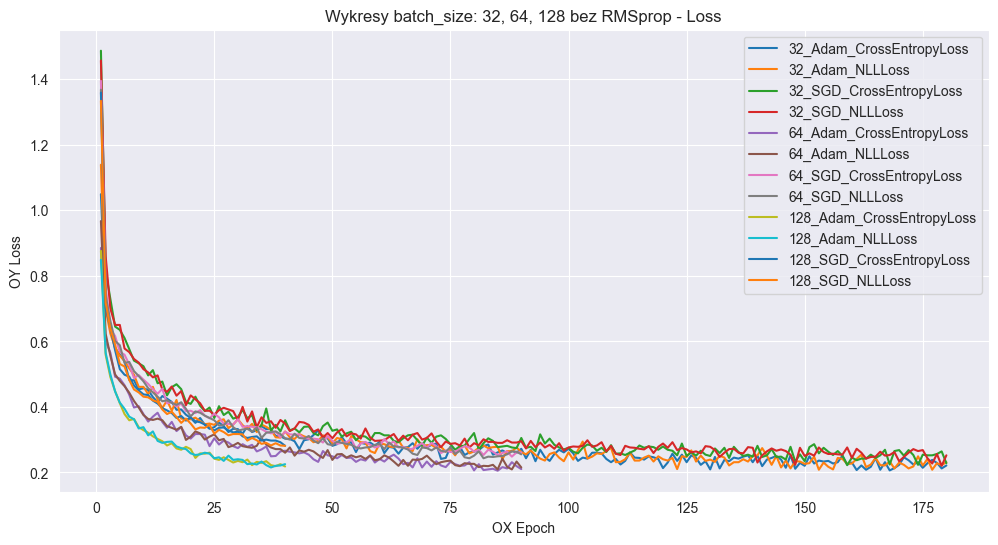

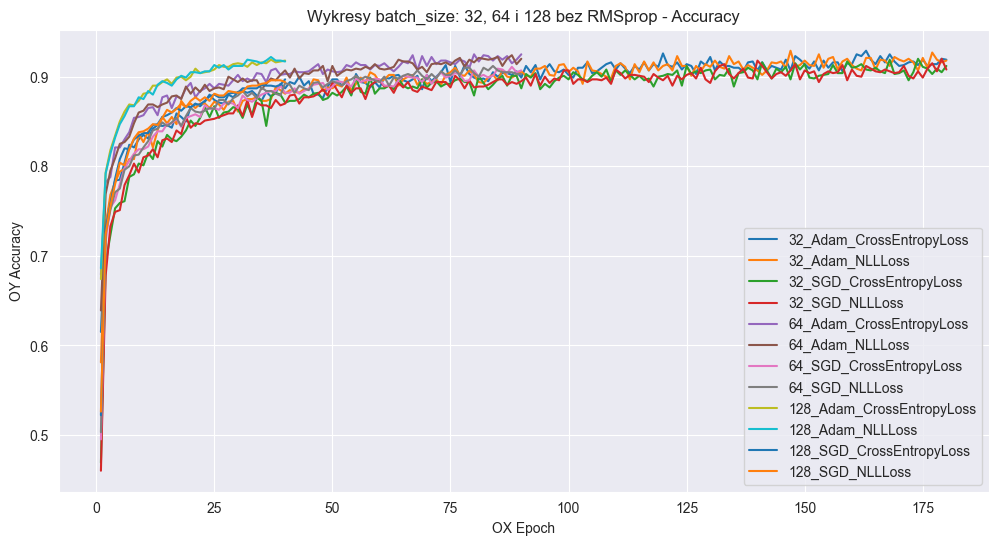

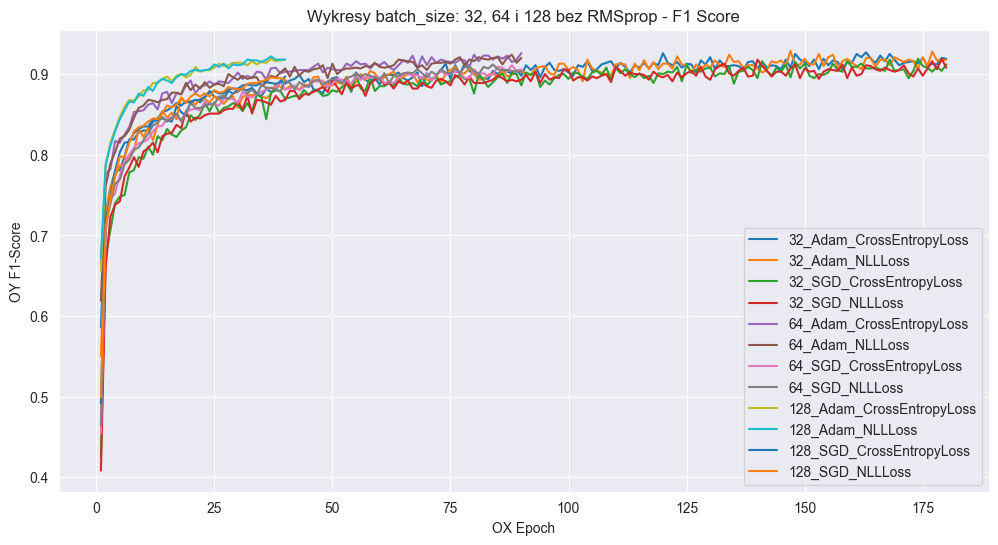

In [321]:
plot_data([b_32_X, b_64_X, b_128_X], [b_32_Y_losses, b_64_Y_losses, b_128_Y_losses], [b_32_l, b_64_l, b_128_l], "Wykresy batch_size: 32, 64, 128 bez RMSprop - Loss", "Epoch", "Loss")
plot_data([b_32_X, b_64_X, b_128_X], [b_32_Y_accuracies, b_64_Y_accuracies, b_128_Y_accuracies], [b_32_l, b_64_l, b_128_l], "Wykresy batch_size: 32, 64 i 128 bez RMSprop - Accuracy", "Epoch", "Accuracy")
plot_data([b_32_X, b_64_X, b_128_X], [b_32_Y_f1_scores, b_64_Y_f1_scores, b_128_Y_f1_scores], [b_32_l, b_64_l, b_128_l], "Wykresy batch_size: 32, 64 i 128 bez RMSprop - F1 Score", "Epoch", "F1-Score")

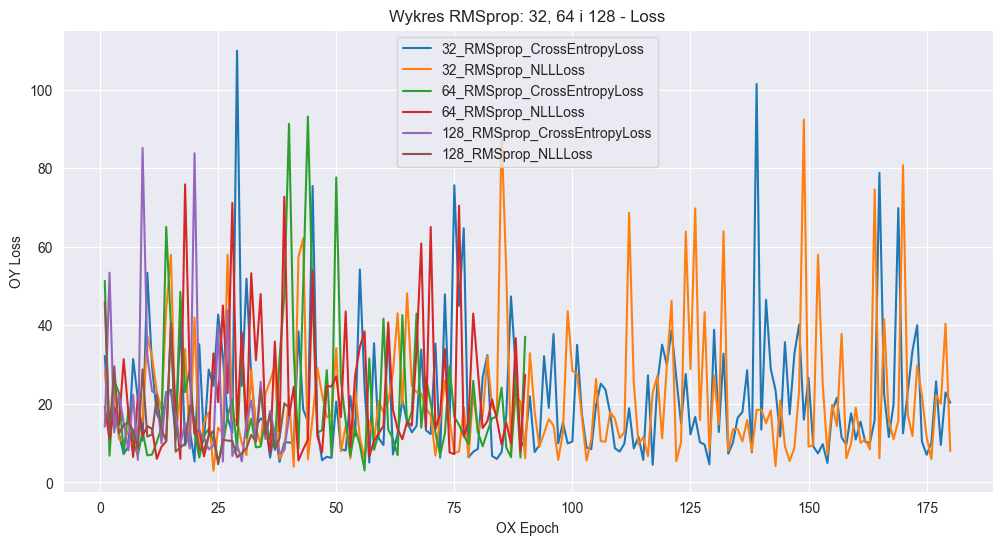

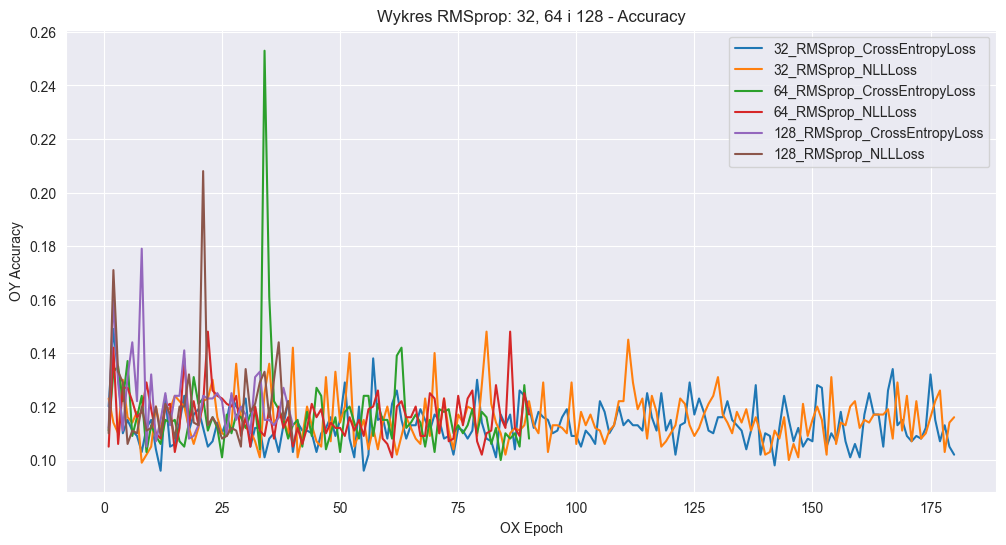

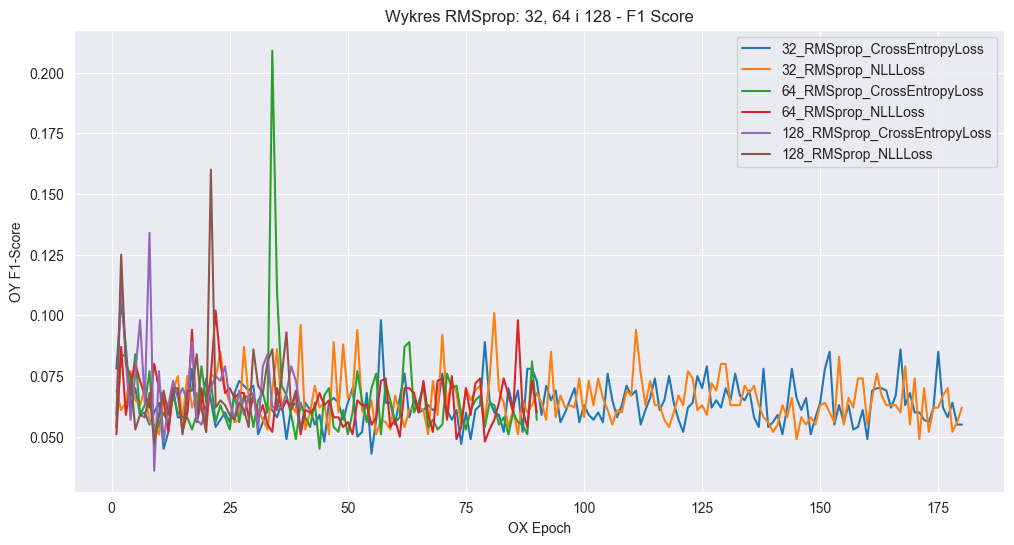

In [322]:
plot_data([b_rmsprop_32_X, b_rmsprop_64_X, b_rmsprop_128_X], [b_rmsprop_32_Y_losses, b_rmsprop_64_Y_losses, b_rmsprop_128_Y_losses], [b_rmsprop_32_l, b_rmsprop_64_l, b_rmsprop_128_l], "Wykres RMSprop: 32, 64 i 128 - Loss", "Epoch", "Loss")
plot_data([b_rmsprop_32_X, b_rmsprop_64_X, b_rmsprop_128_X], [b_rmsprop_32_Y_accuracies, b_rmsprop_64_Y_accuracies, b_rmsprop_128_Y_accuracies], [b_rmsprop_32_l, b_rmsprop_64_l, b_rmsprop_128_l], "Wykres RMSprop: 32, 64 i 128 - Accuracy", "Epoch", "Accuracy")
plot_data([b_rmsprop_32_X, b_rmsprop_64_X, b_rmsprop_128_X], [b_rmsprop_32_Y_f1_scores, b_rmsprop_64_Y_f1_scores, b_rmsprop_128_Y_f1_scores], [b_rmsprop_32_l, b_rmsprop_64_l, b_rmsprop_128_l], "Wykres RMSprop: 32, 64 i 128 - F1 Score", "Epoch", "F1-Score")

Podsumowanie:
- W kwestii wyników, porównując z ręcznymi poszukiwaniami to napewno optymalizator się zgadza, czyli Adam, ewidentnie na wykresach stworzonych z działań Parameter Gridu dla 128_Adam_CrossEntropyLoss oraz 128_Adam_NLLLoss, Adam uzyskuje najwyższe wartości accuracy, f1-score oraz najszybsze spadki wartości loss. Dzieje się to najszybciej dla większego rozmiaru batch_size co pokrywało by sie z przesłankami teoretycznymi. Ponieważ na ogół większe batche mogą skrócić czas uczenia, ponieważ obliczenia można wykonać równolegle na większej liczbie danych. Eksperymenty te bazowałem jednak na zbiorze Fashion MNIST, a więc niezbyt skomplikowanym datasecie, ani w żaden sposób specyficznym. Raczej spodziewanym był wynik najlepszy dla Adama i CrossEntropyLoss.
- Niestety ale próbowanie kombinacji ParameterGrid musiałem próbować "pół automatycznie" z uwagi na ogranicznie sprzętowe i brak współpracy po stronie Google Colab :)
- Jednakże przy odpowiednio wysokich parametrach sprzętowych, szczególnie w przypadku przetwarzania obrazu, procesorach graficznych GPU i wykorzystaniu technologii obliczeń równoległych np NVIDIA CUDA w relatywnie krótkim czasie, łatwo można uzyskać najlepsze parametry dla danego problemu, wykorzystująć "brute force" w postaci, testowania wszystkich możliwych kombinacji zadanych parametrów.
- W przypadku RMSprop wyniki wydają się być dość abstrakcyjne, model zdaje się być całkowicie rozkalibrowany. Jednakże prawie napewno wynika to z podanych argumentów: {'lr': 0.01, 'alpha': 0.9, 'eps': 1e-08, 'weight_decay': 5e-4, 'momentum': 0.9, 'centered': False}. Zarówno RMSprop jak i Adam to metody gradientowe szukania ekstremów, cechuje je w obu wypadkach wysoka skuteczność, często RMSprop nawet wyższa, co można zauważyć czytając źródło: [https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)

![RMSpropVSAdam](results/RMSpropVSAdam.png)

- Adam jak i RMSprop posiadają wiele podobieństw, takich jak: adaptacyjne skalowanie gradientów, czy wykorzystanie średniej kroczącej. RMSprop jest znany z większej stabilności, ale często wolniej osiąga punkt konwergencji modelu (punkt w procesie uczenia polegający na osiągnięciu stabilności i zbieganiu do punktu, w którum funkcja straty osiąga minimalną wartość lub jest zbliżona do niej - model przestaje się istotnie zmieniać i jego dokładność lub wydajność na zbiorze testowym przestaje się istotnie poprawiać) w stodunku do Adama. Jednakże można także wymienić istotne różnice, gdzie najwaznieszą z nich będzie: większa wrażliwość na hiperparametry po stronie RMSprop (co jest prawdopodobnym błędem w moim przypadku).
- W kwesti "Hyperparameter Tunning" jest to technika, która lepiej była by widoczna w przypadku bardziej skomplikowanych problemów. W moich modelach udało mi się wytypować mniej więcej najlepsze parametry. Oprócz Grid Search można również skorzystać z innych sposobów typowania najlepszych parametrów, jak: Random Search, Bayesian Optimization czy Algorytmy Genetyczne.